<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Общая-информация" data-toc-modified-id="Общая-информация-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Общая информация</a></span></li><li><span><a href="#Лемматизация" data-toc-modified-id="Лемматизация-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Лемматизация</a></span></li><li><span><a href="#Vectorizes-&amp;-Pipeline" data-toc-modified-id="Vectorizes-&amp;-Pipeline-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Vectorizes &amp; Pipeline</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#BERT" data-toc-modified-id="BERT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>BERT</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Токсичные комментарии с BERT

## Подготовка

In [1]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import torch
import transformers
from tqdm import notebook
from transformers import DistilBertTokenizer, DistilBertModel

In [2]:
uploaded = files.upload()

Saving toxic_comments.csv to toxic_comments.csv


In [3]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [4]:
RANDOM = 6253

### Общая информация

In [5]:
data = pd.read_csv(io.StringIO(uploaded['toxic_comments.csv'].decode('utf-8')))

In [6]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


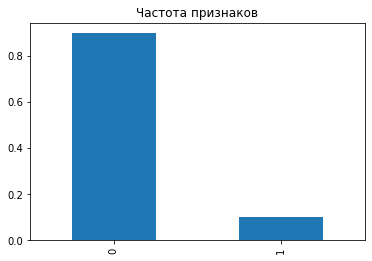

0    0.898321
1    0.101679
Name: toxic, dtype: float64


In [7]:
class_frequency = data['toxic'].value_counts(normalize=True)
class_frequency.plot(kind='bar')
plt.title('Частота признаков')
plt.show()
print(class_frequency)

**Вывод**

Представлен датасет с комментариями пользователей и оценкой их токсичности.  
Почти 90% отмечены как не токсичные.

### Лемматизация

In [8]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z,а-яА-ЯёЁ]', ' ', text)
    text = text.split()
    return " ".join(text) 

data['clear'] = data['text'].apply(lambda x: clear_text(x))

In [9]:
%%time
def lemmatize(text):
    doc = nlp(text)
    lemm_list = [token.lemma_ for token in doc]
    lemm_text = " ".join(lemm_list) 
    return lemm_text

data['lemmas'] = data['clear'].apply(lambda x: lemmatize(x))

CPU times: user 12min 52s, sys: 1min 13s, total: 14min 6s
Wall time: 14min 3s


In [10]:
data.head()

,text,toxic,clear,lemmas
0,Explanation\nWhy the edits made under my usern...,0,Explanation Why the edits made under my userna...,explanation why the edit make under -PRON- use...
1,D'aww! He matches this background colour I'm s...,0,D aww He matches this background colour I m se...,D aww -PRON- match this background colour -PRO...
2,"Hey man, I'm really not trying to edit war. It...",0,"Hey man, I m really not trying to edit war It ...","hey man , -PRON- m really not try to edit war ..."
3,"""\nMore\nI can't make any real suggestions on ...",0,More I can t make any real suggestions on impr...,More -PRON- can t make any real suggestion on ...
4,"You, sir, are my hero. Any chance you remember...",0,"You, sir, are my hero Any chance you remember ...","-PRON- , sir , be -PRON- hero any chance -PRON..."


**Вывод**

Данные очищены и лемматизированны при помощи spaCy.

### Vectorizes & Pipeline

In [11]:
X = data['lemmas']
y = data['toxic']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM)

In [13]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [14]:
pipeline_lr_bow = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression())
])

pipeline_lr_tf_idf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

In [15]:
params_lr = {
    'vect__stop_words': [stopwords],
    'vect__ngram_range': ((1, 1), (1, 2)),
    'clf__random_state': [RANDOM],
    'clf__max_iter': (500, 1000),
}

In [16]:
grid_lr_bow = GridSearchCV(pipeline_lr_bow, params_lr, cv=5, n_jobs=-1, verbose=1)
grid_lr_tf_idf = GridSearchCV(pipeline_lr_tf_idf, params_lr, cv=5, n_jobs=-1, verbose=1)

In [17]:
pipeline_rf_bow = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

pipeline_rf_tf_idf = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [18]:
params_rf = {
    'vect__stop_words': [stopwords],
    'clf__random_state': [RANDOM],
}

In [19]:
grid_rf_bow = GridSearchCV(pipeline_rf_bow, params_rf, cv=5, n_jobs=-1, verbose=1)
grid_rf_tf_idf = GridSearchCV(pipeline_rf_tf_idf, params_rf, cv=5, n_jobs=-1, verbose=1)

**Вывод**

Созданы пайплайны для разных способов векторизации и моделей с учетом стоп-слов и биграмм.

## Обучение

### LogisticRegression

In [20]:
grid_lr_bow.fit(X_train, y_train)
model_lr_bow = grid_lr_bow.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 32.9min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [21]:
pred = model_lr_bow.predict(X_test)
bow_lr_f1 = f1_score(y_test, pred)
print('F1 CountVectorizer:', bow_lr_f1)

F1 CountVectorizer: 0.7632489276324893


In [22]:
grid_lr_tf_idf.fit(X_train, y_train)
model_lr_tf = grid_lr_tf_idf.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [23]:
pred = model_lr_tf.predict(X_test)
tf_idf_lr_f1 = f1_score(y_test, pred)
print('F1 TfidfVectorizer:', tf_idf_lr_f1)

F1 TfidfVectorizer: 0.7357899448008354


### RandomForestClassifier

In [24]:
grid_rf_bow.fit(X_train, y_train)
model_rf_bow = grid_rf_bow.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 27.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [25]:
pred = model_rf_bow.predict(X_test)
bow_rf_f1 = f1_score(y_test, pred)
print('F1 CountVectorizer:', bow_rf_f1)

F1 CountVectorizer: 0.7266508030933967


In [26]:
grid_rf_tf_idf.fit(X_train, y_train)
model_rf_tf = grid_rf_tf_idf.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 23.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [27]:
pred = model_rf_tf.predict(X_test)
tf_idf_rf_f1 = f1_score(y_test, pred)
print('F1 TfidfVectorizer:', tf_idf_rf_f1)

F1 TfidfVectorizer: 0.7204837490551776


**Вывод**

Лучший результат метрики при векторизации с помощью мешка слов на модели логистической регрессии.

### BERT

In [28]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
data_bert = data.sample(3000, random_state=RANDOM)
data_bert['toxic'].value_counts(normalize=True)

0    0.9
1    0.1
Name: toxic, dtype: float64

In [30]:
%%time
tokenized = data_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

CPU times: user 6.21 s, sys: 40.9 ms, total: 6.25 s
Wall time: 6.25 s


In [31]:
max_len = max(tokenized.apply(lambda x: len(x)))
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [32]:
%%time
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)
        
        with torch.no_grad():
            model.to(device)
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        del batch
        del attention_mask_batch
        del batch_embeddings

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1min 40s, sys: 999 ms, total: 1min 41s
Wall time: 1min 47s


In [33]:
X_bert = np.concatenate(embeddings)
y_bert = data_bert['toxic']
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert, y_bert, test_size=0.25, stratify=y_bert, random_state=RANDOM)

In [34]:
model_bert = LogisticRegression(max_iter=700, random_state=RANDOM)
model_bert.fit(X_train_bert, y_train_bert)

pred = model_bert.predict(X_test_bert)
bert_f1 = f1_score(y_test_bert, pred)
print('F1 BERT:', bert_f1)

F1 BERT: 0.7737226277372263


**Вывод**

Для достижения необходимого уровня метрики с помощью BERT возможно использование уменьшенной выборки, однако для расчета требуются большие вычислительные мощности, чем при использовании мешка слов или TF-IDF.

## Выводы

In [35]:
overall = pd.DataFrame({
    'Vectorizer & Model': ['LogisticRegression & CountVectorizer', 'LogisticRegression & TfidfVectorizer',
                           'RandomForestClassifier & CountVectorizer', 'RandomForestClassifier & TfidfVectorizer', 'BERT'], 
    'F1': [bow_lr_f1, tf_idf_lr_f1, bow_rf_f1, tf_idf_rf_f1, bert_f1],
    'sample count': [data.shape[0], data.shape[0], data.shape[0], data.shape[0], data_bert.shape[0]]
})
overall.sort_values(by='F1', ascending=False)

,Vectorizer & Model,F1,sample count
4,BERT,0.773723,3000
0,LogisticRegression & CountVectorizer,0.763249,159571
1,LogisticRegression & TfidfVectorizer,0.735790,159571
2,RandomForestClassifier & CountVectorizer,0.726651,159571
3,RandomForestClassifier & TfidfVectorizer,0.720484,159571


**Вывод**

Лучший результат при использовании наименьшего объема данных у модели, обученной с помощью BERT, F1 = 0.77.  
Модель, обученная на полном наборе данных с помощью мешка слов также имеет достаточно высокий результат F1 = 0.76.  
Подготовка данных для мешка слов и TF-IDF требует меньшее количество ресурсов, чем подготовка данных для BERT.